In [1]:
from src.utils import get_matches

import datasets
from collections import Counter
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
import numpy as np
from math import log10
import seaborn as sns
import tiktoken

sns.set_style('whitegrid')


In [2]:
# load matches
dataset = datasets.load_dataset("FAERS-PubMed/raw_dataset")
matches = get_matches(dataset['train'])
print(len(matches))

Using custom data configuration FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2
Found cached dataset json (/Users/kldooste/.cache/huggingface/datasets/FAERS-PubMed___json/FAERS-PubMed--raw_dataset-0b83cc0b498dbbb2/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

65648


## Exploring some fields


In [3]:
# m = matches[12346]
m = matches[12360]

print(m.article.title)
print(len(m.article.abstract))
print(m.article.abstract)
print(len(m.article.fulltext))
print(m.article.fulltext)
print(len(m.reports))

Does Carboplatin Rapid Desensitization Change Its Adverse Drug Reactions Other than Hypersensitivity and Efficacy in Patients With Ovarian Cancer?
1522
OBJECTIVE
Rapid drug desensitization is known to be a good strategy in patients with drug hypersensitivity to chemotherapy. However, changes in maximal drug concentration and exposure time in blood through desensitization may alter other adverse reactions and efficacy of the drug. We investigated rapid desensitization for carboplatin in terms of severe adverse drug reactions (ADRs) and efficacy compared with the standard infusion.


METHODS
A retrospective cohort study was conducted on patients with recurrent ovarian cancer who received carboplatin chemotherapy from 2017 to 2019. We compared serious adverse events (SAEs), ADRs according to organ classes, time to progression (TTP), and overall survival (OS).


RESULTS
Of 108 desensitization procedures performed in 21 patients, 104 were successfully accomplished (96.3%). There were compar

In [4]:
m.reports[0].dict()

{'safetyreportid': 19430235,
 'safetyreportversion': 1,
 'occurcountry': 'KR',
 'primarysourcecountry': 'KR',
 'fulfillexpeditecriteria': '1',
 'companynumb': 'KR-MYLANLABS-2021M1035082',
 'primarysource': {'reportercountry': 'KR',
  'qualification': '1',
  'literaturereference': 'PARK H?K, LEE SJ, KIM S, LEE J?M, HONG DG. DOES CARBOPLATIN RAPID DESENSITIZATION CHANGE ITS ADVERSE DRUG REACTIONS OTHER THAN HYPERSENSITIVITY AND EFFICACY IN PATIENTS WITH OVARIAN CANCER? ALLERGY?ASTHMA?IMMUNOL?RES 2020?12(6):1046?1059.',
  'literaturereference_normalized': 'does carboplatin rapid desensitization change its adverse drug reactions other than hypersensitivity and efficacy in patients with ovarian cancer'},
 'sender': {'sendertype': '2', 'senderorganization': 'FDA-Public Use'},
 'receiver': {'receivertype': '6', 'receiverorganization': 'FDA'},
 'reporttype': '2',
 'receivedate': '20210617',
 'receiptdate': '20210617',
 'patient': {'patientagegroup': None,
  'patientonsetage': None,
  'patiento

In [5]:
m.reports[1].dict()

{'safetyreportid': 18473245,
 'safetyreportversion': 3,
 'occurcountry': 'KR',
 'primarysourcecountry': 'KR',
 'fulfillexpeditecriteria': '1',
 'companynumb': 'KR-PFIZER INC-2020429771',
 'primarysource': {'reportercountry': 'KR',
  'qualification': '1',
  'literaturereference': 'PARK, H.. DOES CARBOPLATIN RAPID DESENSITIZATION CHANGE ITS ADVERSE DRUG REACTIONS OTHER THAN HYPERSENSITIVITY AND EFFICACY IN PATIENTS WITH OVARIAN CANCER?. ALLERGY, ASTHMA AND IMMUNOLOGY RESEARCH. 2020?12 (6):1046-1059',
  'literaturereference_normalized': 'does carboplatin rapid desensitization change its adverse drug reactions other than hypersensitivity and efficacy in patients with ovarian cancer'},
 'sender': {'sendertype': '2', 'senderorganization': 'FDA-Public Use'},
 'receiver': {'receivertype': '6', 'receiverorganization': 'FDA'},
 'reporttype': '2',
 'receivedate': '20201106',
 'receiptdate': '20201123',
 'patient': {'patientagegroup': None,
  'patientonsetage': None,
  'patientonsetageunit': None,

## Simple statistics

In [6]:
print(f'Number of unique articles: {len(matches):,}')
print(f'Number of unique articles with an abstract: {len([m for m in matches if m.article.abstract]):,}')
print(f'Number of unique articles with a full-text: {len([m for m in matches if m.article.fulltext]):,}')
print()
print(f'Number of unique reports: {sum([len(m.reports) for m in matches]):,}')

Number of unique articles: 65,648
Number of unique articles with an abstract: 65,648
Number of unique articles with a full-text: 19,433

Number of unique reports: 256,240


In [7]:
abstract_length = np.array([len(m.article.abstract) for m in matches])
print(f'Average abstract length: {round(abstract_length.mean()):,}')
fulltext_length = np.array([len(m.article.fulltext) for m in matches if m.article.fulltext])
print(f'Average fulltext length: {round(fulltext_length.mean()):,}')

Average abstract length: 1,277
Average fulltext length: 23,767


In [8]:
drugs = []
reactions = []

def process(text):
    return text.lower().strip()

for m in matches:
    for r in m.reports:
        for drug in r.patient.drug:
            if drug.activesubstance and drug.activesubstance.activesubstancename:
                drugs.append(process(drug.activesubstance.activesubstancename))
        for reaction in r.patient.reaction:
            if reaction.reactionmeddrapt:
                reactions.append(process(reaction.reactionmeddrapt))

print(f'Amount of drugs: {len(drugs):,}')
print(f'Amount of unique drugs: {len(set(drugs)):,}')
print(f'Amount of reactions: {len(reactions):,}')
print(f'Amount of unique reactions: {len(set(reactions)):,}')

Amount of drugs: 1,062,969
Amount of unique drugs: 5,227
Amount of reactions: 741,940
Amount of unique reactions: 11,271


## Licenses

In [9]:
# noncommercial_licenses = {'CC BY-NC', 'CC BY-NC-SA', 'CC BY-NC-ND'}
commercial_licenses = {'CC0', 'CC BY', 'CC BY-SA', 'CC BY-ND'}

matches_commercial = [m for m in matches if m.article.fulltext_license in commercial_licenses]
print(f'Fulltext commercial dataset: {len(matches_commercial):,}')

Fulltext commercial dataset: 9,206


## Study the origin of the articles and reports

In [402]:
def normalize_countries(countries):
    countries = [c for c in countries if c or c != 'None' or c != 'COUNTRY NOT SPECIFIED']
    countries_norm = []
    for c in countries:
        if c == 'England' or c == 'Scotland':
            countries_norm.append('United Kingdom')
        else:
            countries_norm.append(c)
    countries_iso3 = coco.convert(names=countries_norm, to='ISO3', not_found='NULL')
    return countries_iso3

def plot_world_heatmap(countries, title='', log=True, annotate=False):
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_map = world_map.drop(world_map[world_map['name'] == 'Antarctica'].index)

    print(world_map.head())

    # countries_iso3 = normalize_countries(countries)
    counts = Counter(countries)

    world_map['occurances'] = world_map['iso_a3'].apply(lambda x: counts[x])
    world_map['occurances_log'] = world_map['occurances'].apply(lambda x: log10(x) if x else 0)

    if log:
        plot = world_map.plot(figsize=(20, 20), edgecolor='white', linewidth=1, column='occurances_log', cmap='viridis', legend=False)
    else:
        plot = world_map.plot(figsize=(20, 20), edgecolor='white', linewidth=1, column='occurances', cmap='viridis', legend=False)

    # remove axes
    plot.set_axis_off()
    

    # add legend
    cbar = plt.colorbar(plot.collections[0], fraction=0.015)
    cbar.ax.set_ylabel('Log Occurrences' if log else 'Occurrences')
    cbar.ax.get_yaxis().labelpad = 20

    plt.title(title)
    plt.show()

def plot_world_heatmap_ax(ax, countries, log=True, title=''):
    world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world_map = world_map.drop(world_map[world_map['name'] == 'Antarctica'].index)

    # countries_iso3 = normalize_countries(countries)
    counts = Counter(countries)

    world_map['occurances'] = world_map['iso_a3'].apply(lambda x: counts[x])
    world_map['occurances_log'] = world_map['occurances'].apply(lambda x: log10(x) if x else 0)

    if log:
        plot = world_map.plot(ax=ax, figsize=(6, 6), edgecolor='white', linewidth=1, column='occurances_log', cmap='viridis', legend=False)
    else:
        plot = world_map.plot(ax=ax, figsize=(6, 6), edgecolor='white', linewidth=1, column='occurances', cmap='viridis', legend=False)

    # remove axes
    plot.set_axis_off()

    # # add legend
    # cbar = plt.colorbar(plot.collections[0], ax=ax, fraction=0.02)
    # cbar.ax.set_ylabel('Log Occurrences' if log else 'Occurrences')
    # cbar.ax.get_yaxis().labelpad = 20

    # set title
    ax.set_title(title)

    return plot

In [403]:
report_occur = normalize_countries([r.occurcountry for m in matches for r in m.reports])
# article_countries = normalize_countries([m.article.country for m in matches])
# report_primarysource = normalize_countries([r.primarysourcecountry for m in matches for r in m.reports])
# report_reportercountry = normalize_countries([r.primarysource.reportercountry for m in matches for r in m.reports])


None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
A1 not found in ISO2
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in regex
None not found in r

In [404]:
sorted(list(Counter(report_occur).items()), key=lambda x: x[1], reverse=True)

[('USA', 110438),
 ('JPN', 19750),
 ('ITA', 12359),
 ('DEU', 10564),
 ('FRA', 10163),
 ('GBR', 9800),
 ('CHN', 6642),
 ('ESP', 6499),
 ('TUR', 5782),
 ('IND', 5669),
 ('CAN', 5280),
 ('AUS', 5004),
 ('NLD', 4223),
 ('KOR', 3175),
 ('BRA', 2291),
 ('POL', 2222),
 ('PRT', 2192),
 ('DNK', 2154),
 ('CHE', 2058),
 ('TWN', 1998),
 ('BEL', 1854),
 ('SWE', 1574),
 ('ISR', 1488),
 ('GRC', 1326),
 ('IRN', 1281),
 ('AUT', 1110),
 ('SAU', 1071),
 ('ZAF', 1016),
 ('FIN', 937),
 ('THA', 901),
 ('NOR', 828),
 ('IRL', 811),
 ('EGY', 768),
 ('SGP', 665),
 ('NULL', 656),
 ('MEX', 641),
 ('CZE', 639),
 ('NZL', 587),
 ('ROU', 473),
 ('RUS', 465),
 ('BWA', 462),
 ('HKG', 454),
 ('ARG', 445),
 ('MYS', 415),
 ('TUN', 401),
 ('HRV', 398),
 ('HUN', 352),
 ('PAK', 343),
 ('SVN', 294),
 ('COL', 293),
 ('CHL', 259),
 ('SRB', 253),
 ('QAT', 237),
 ('LBN', 224),
 ('MAR', 209),
 ('UGA', 199),
 ('IDN', 176),
 ('LKA', 164),
 ('NGA', 161),
 ('ARE', 150),
 ('JOR', 143),
 ('SVK', 132),
 ('NPL', 131),
 ('KEN', 126),
 ('TZ

       pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  


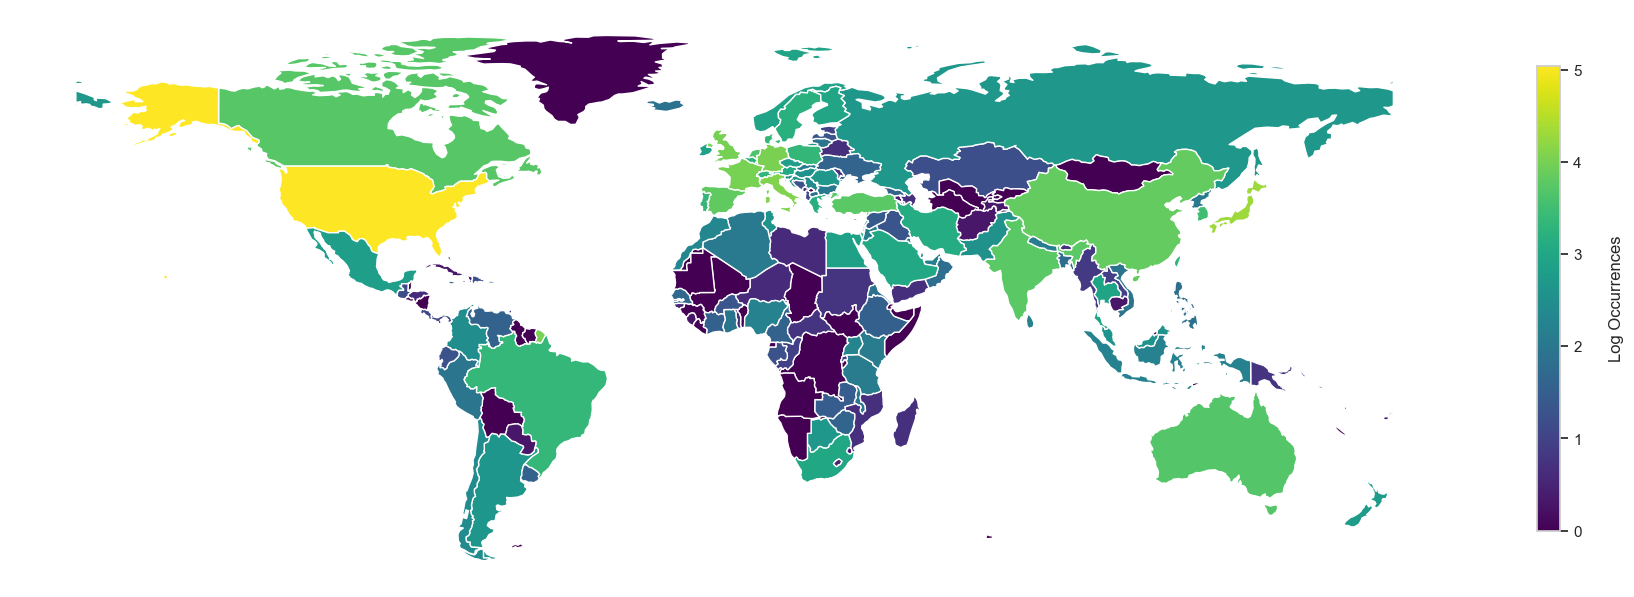

In [405]:
plot_world_heatmap(report_occur, None)


       pop_est      continent                      name iso_a3  gdp_md_est  \
0     889953.0        Oceania                      Fiji    FJI        5496   
1   58005463.0         Africa                  Tanzania    TZA       63177   
2     603253.0         Africa                 W. Sahara    ESH         907   
3   37589262.0  North America                    Canada    CAN     1736425   
4  328239523.0  North America  United States of America    USA    21433226   

                                            geometry  
0  MULTIPOLYGON (((180.00000 -16.06713, 180.00000...  
1  POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...  
2  POLYGON ((-8.66559 27.65643, -8.66512 27.58948...  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  


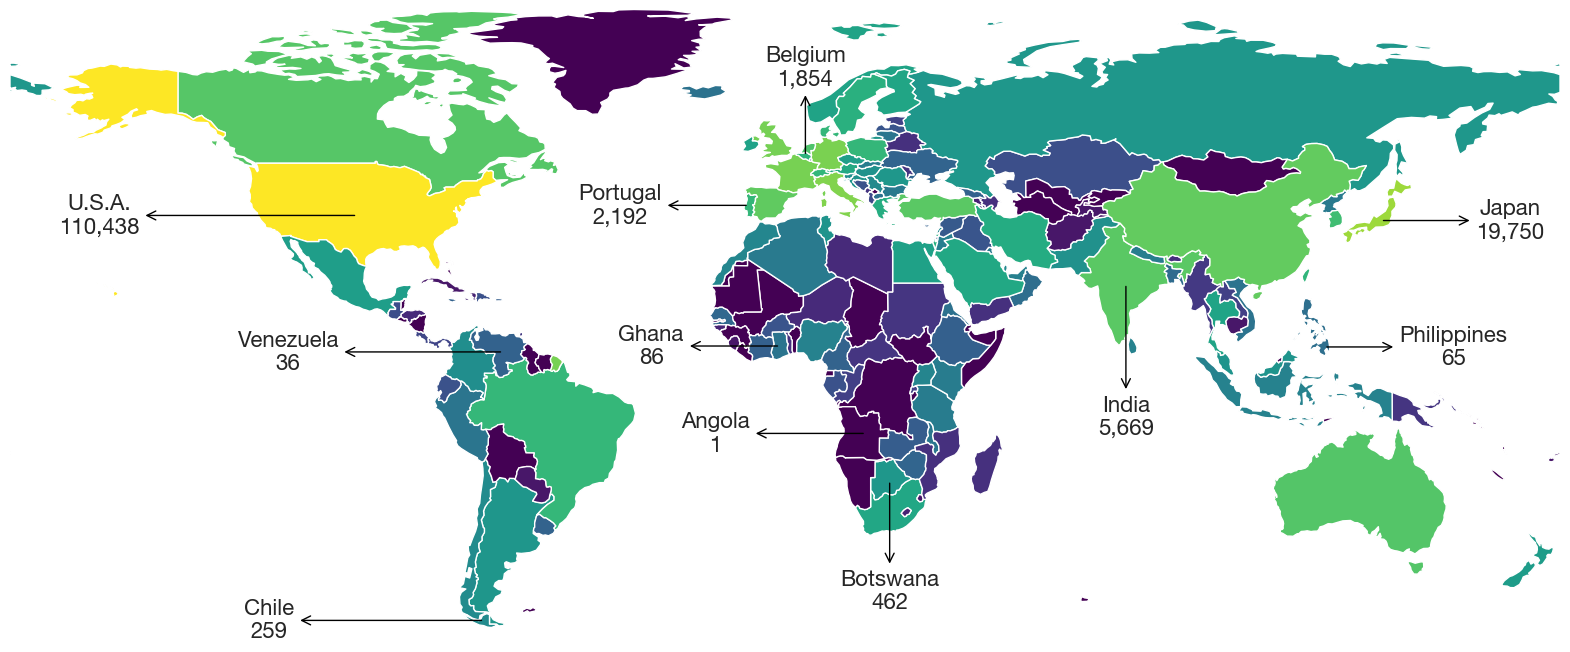

In [424]:
from matplotlib.font_manager import FontProperties

countries = report_occur
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_map = world_map.drop(world_map[world_map['name'] == 'Antarctica'].index)

print(world_map.head())

# countries_iso3 = normalize_countries(countries)
counts = Counter(countries)

world_map['occurances'] = world_map['iso_a3'].apply(lambda x: counts[x])
world_map['occurances_log'] = world_map['occurances'].apply(lambda x: log10(x) if x else 0)

plot = world_map.plot(figsize=(20, 20), edgecolor='white', linewidth=1, column='occurances_log', cmap='viridis', legend=False)

# remove axes
plot.set_axis_off()
plot.margins(0)

# annotate
world_map_by_iso = world_map.set_index('iso_a3')
world_map_by_iso['coords'] = world_map_by_iso['geometry'].apply(lambda x: x.representative_point().coords[:])
world_map_by_iso['coords'] = [coords[0] for coords in world_map_by_iso['coords']]

arrowprops = dict(
    arrowstyle="<-",
    color='black')

# Set the font properties for annotation text
font_path = '/System/Library/Fonts/HelveticaNeue.ttc'  # Replace with the path to the Helvetica font file
helvetica_font = FontProperties(fname=font_path)



to_annotate = ['USA', 'BEL', 'JPN', 'CHL', 'VEN', 'GHA', 'IND', 'AGO', 'BWA', 'PHL', 'PRT']
offsets = [(-60, 0), (0, 20), (30,0), (-50, 0), (-50, 0), (-30, 0), (0, -30), (-35,0), (0,-25), (30,0), (-30,0)]
for annotate, offset in zip(to_annotate, offsets):
    name = world_map_by_iso.loc[annotate]['name']
    occurance = world_map_by_iso.loc[annotate]['occurances']
    coords = world_map_by_iso.loc[annotate]['coords']

    coords_with_offset = (coords[0] + offset[0], coords[1] + offset[1])

    if annotate == 'USA':
        name = 'U.S.A.'

    plt.annotate(f'{name:}\n{occurance:,}',
                 xy=coords,
                 xytext=coords_with_offset,
                 arrowprops=arrowprops,
            annotation_clip=False,
            ha='center',
            va='center',
            fontproperties=helvetica_font,
            fontsize=16)

# add legend
# cbar = plt.colorbar(plot.collections[0], fraction=0.015)
# cbar.ax.set_ylabel('Log Occurrences')
# cbar.ax.get_yaxis().labelpad = 20
plt.savefig('./plots/worldmap_annotated.png', dpi=300,  bbox_inches='tight')
plt.show()


## Study dates

In [55]:
from datetime import datetime

article_dates = [m.article.pubdate for m in matches]

report_receive = [r.receivedate for m in matches for r in m.reports]
report_receipt = [r.receiptdate for m in matches for r in m.reports]
report_transmisstion = [r.transmissiondate for m in matches for r in m.reports]

# check how many have the full info
def check_info(s):
    if '-' in s:
        return len(s) == 10
    else:
        return len(s) == 8

# only articles have this problem
print(f'{sum([check_info(s) for s in article_dates])} / {len(article_dates)}')
print(f'{sum([check_info(s) for s in report_receive])} / {len(report_receive)}')
print(f'{sum([check_info(s) for s in report_receipt])} / {len(report_receipt)}')
print(f'{sum([check_info(s) for s in report_transmisstion])} / {len(report_transmisstion)}')

def parse_time_report(ls):
    return [datetime.strptime(s, '%Y%m%d') for s in ls]

def parse_time_article(ls):
    return [datetime.strptime(s[:4], '%Y') for s in ls]

article_dates = parse_time_article(article_dates)
report_receive = parse_time_report(report_receive)
report_receipt = parse_time_report(report_receipt)
report_transmisstion = parse_time_report(report_transmisstion)


14670 / 65648
256240 / 256240
256240 / 256240
256240 / 256240


In [91]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib.cm import get_cmap

def plot_dates_bar(dates, title, article=False):
    # Generate some sample datetimes
    if article:
        start_time = datetime(year=min(dates).year, month=1, day=1)
    else:
        start_time = datetime(year=2001, month=1, day=1)
    end_time = datetime(year=2024, month=1, day=1)


    # Define the bin width (1 month in this case)
    bin_width = relativedelta(years=1)

    # Create a list of year starts
    bin_starts = [datetime(start_time.year, 1, 1)]
    while (end_time - bin_starts[-1]).days > 0:
        bin_starts.append(bin_starts[-1] + bin_width)

    # Create the histogram using the bin edges and datetimes
    hist, bins = np.histogram(dates, bins=bin_starts)

    hist = hist.squeeze()
    hist = list(hist)
    bins = bins.squeeze()
    if article:
        bins = [datetime.strftime(b, '\'%y') for b in bins]
    else:
        bins = [datetime.strftime(b, '%Y') for b in bins]

    # Plot the histogram
    plt.figure(figsize=(10,8))
    plt.bar(bins[:-1], hist)
    plt.xticks(rotation=90)
    plt.xlabel('Time')
    plt.ylabel('Count')
    # plt.yscale('log')
    plt.title(title)
    plt.show()

def plot_dates_bar_stacked(dates1, dates2, label1, label2, title):
    # Generate some sample datetimes
    start_time = datetime(year=2000, month=1, day=1)
    end_time = datetime(year=2023, month=1, day=1)


    # Define the bin width (1 year in this case)
    bin_width = relativedelta(years=1)

    # Create a list of year starts
    bin_starts = [datetime(start_time.year, 1, 1)]
    while (end_time - bin_starts[-1]).days > 0:
        bin_starts.append(bin_starts[-1] + bin_width)

    # Create the histogram using the bin edges and datetimes
    hist1, bins1 = np.histogram(dates1, bins=bin_starts)
    hist2, bins2 = np.histogram(dates2, bins=bin_starts)

    hist1 = hist1.squeeze()
    hist1 = list(hist1)
    bins1 = bins1.squeeze()
    bins1 = [datetime.strftime(b, '\'%y') for b in bins1]

    hist2 = hist2.squeeze()
    hist2 = list(hist2)
    bins2 = bins2.squeeze()
    bins2 = [datetime.strftime(b, '\'%y') for b in bins2]

   # Get viridis color cycle
    cmap = get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, 3))

    # Plot the histogram
    plt.figure(figsize=(5,3))
    plt.bar(bins1[:-1], hist1, label=label1, color=colors[0])
    plt.bar(bins2[:-1], hist2, bottom=hist1, label=label2, color=colors[1])
            
    plt.legend()
    plt.xticks(rotation=90)
    plt.xlabel('Time')
    plt.ylabel('Count')
    # plt.yscale('log')
    plt.title(title)
    plt.show()

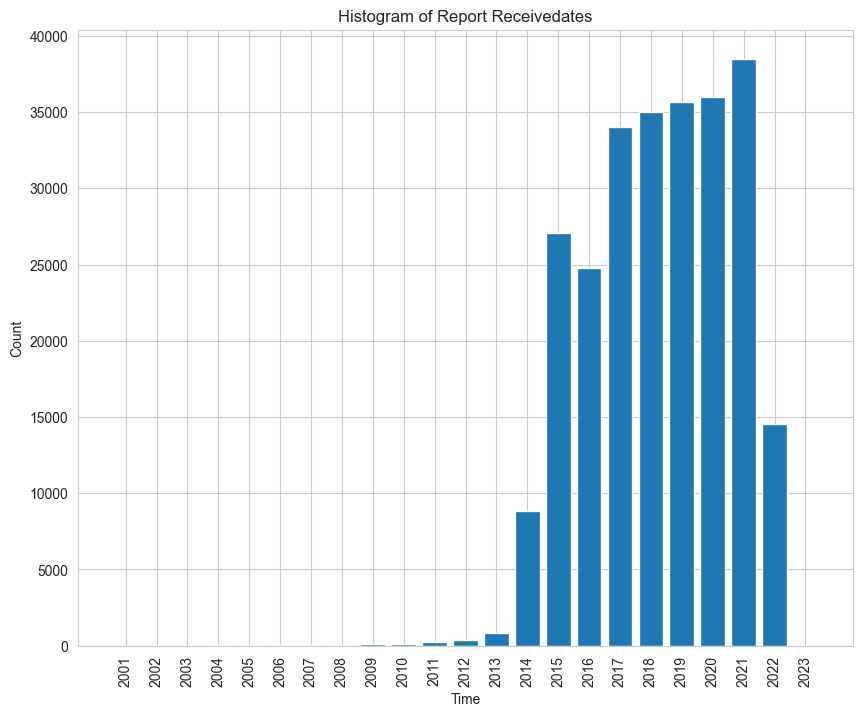

In [92]:
plot_dates_bar(report_receive, 'Histogram of Report Receivedates')


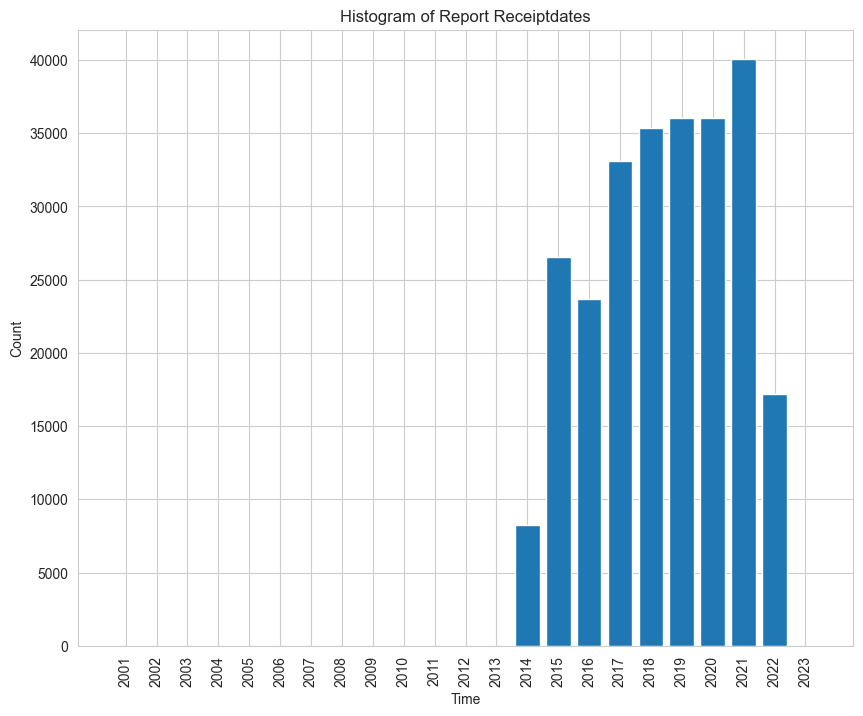

In [93]:
plot_dates_bar(report_receipt, 'Histogram of Report Receiptdates')


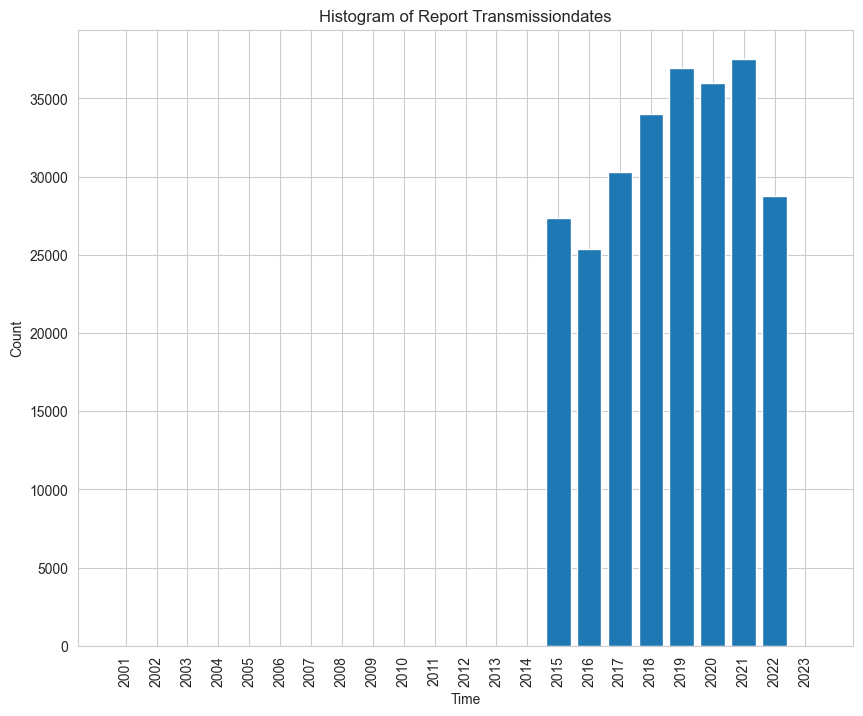

In [94]:
plot_dates_bar(report_transmisstion, 'Histogram of Report Transmissiondates')


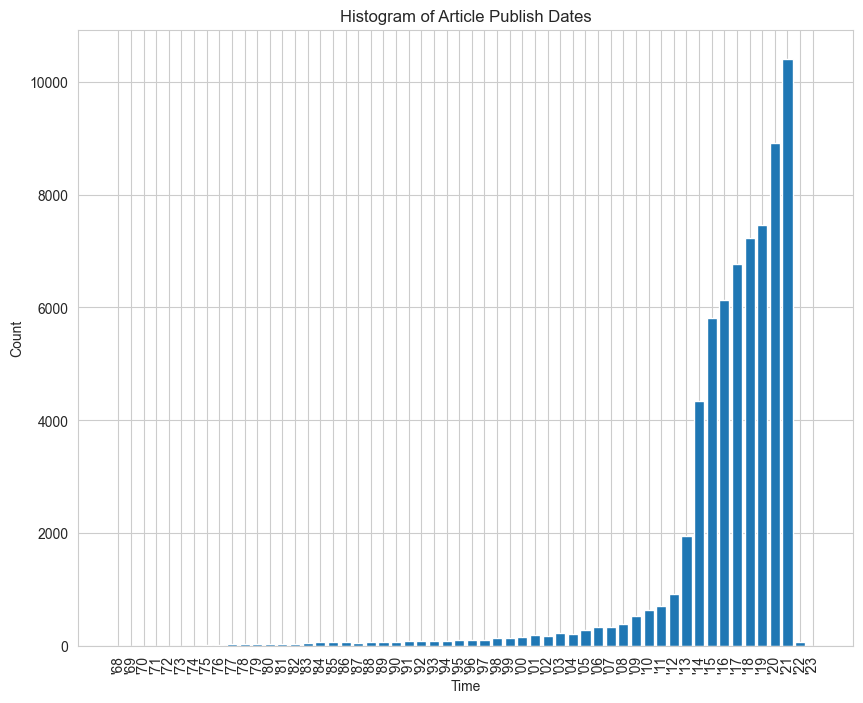

In [95]:
plot_dates_bar(article_dates, 'Histogram of Article Publish Dates', article=True)


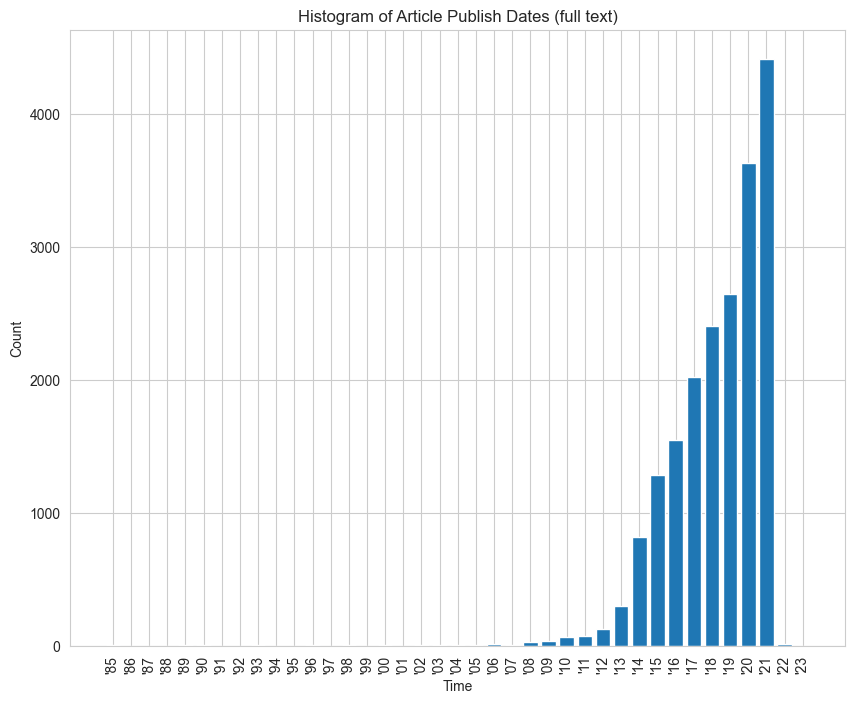

In [96]:
article_dates_fulltext = parse_time_article([m.article.pubdate for m in matches if m.article.fulltext])
plot_dates_bar(article_dates_fulltext, 'Histogram of Article Publish Dates (full text)', article=True)


/var/folders/xp/33m08yl56t1f5z8g9s2h_1j80000gq/T/ipykernel_51259/4166430680.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')


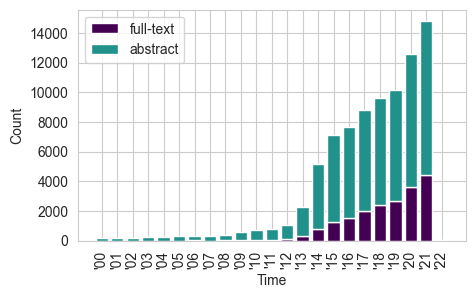

In [97]:
article_dates_fulltext = parse_time_article([m.article.pubdate for m in matches if m.article.fulltext])
article_dates_abstract = parse_time_article([m.article.pubdate for m in matches if not m.article.fulltext])
plot_dates_bar_stacked(article_dates_fulltext, article_dates, 'full-text', 'abstract', None)


In [98]:
min(article_dates_abstract)

datetime.datetime(1968, 1, 1, 0, 0)

## Reports per article


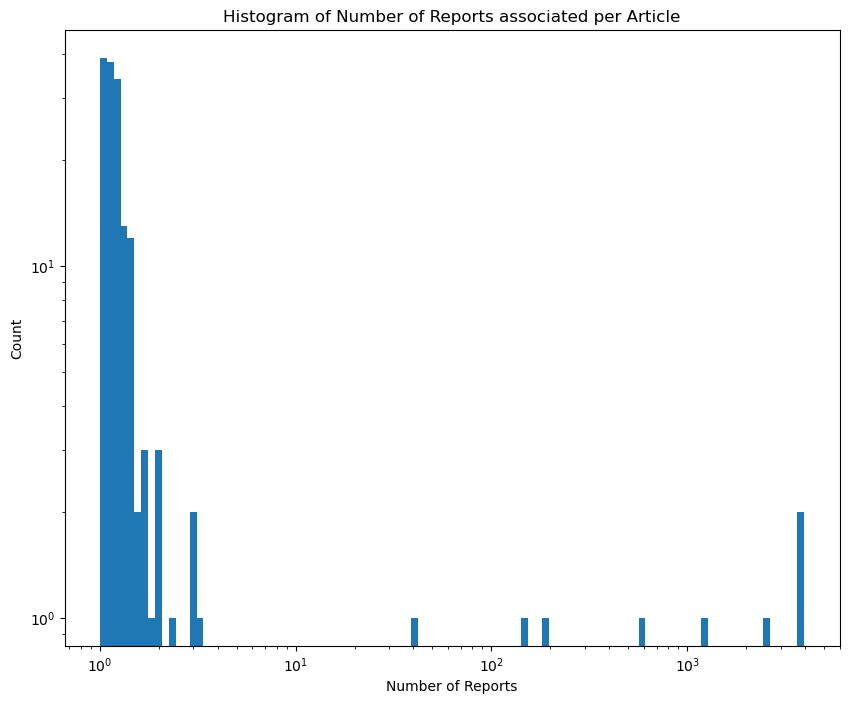

In [ ]:
import numpy as np
from collections import Counter

report_counts = Counter([len(m.reports) for m in matches])
counts, bins = np.histogram(list(report_counts.keys()), bins='auto')
log_bins = np.logspace(np.log10(bins[0]), np.log10(bins[-1]), len(bins))

plt.figure(figsize=(10,8))
plt.bar(log_bins[:-1], counts, width=log_bins[1:] - log_bins[:-1], align='edge')
plt.xscale('log')
plt.yscale('log')
# plt.xticks(log_bins[:-1], [str(int(x)) for x in log_bins[:-1]], rotation=90)
plt.xlabel('Number of Reports')
plt.ylabel('Count')
plt.title('Histogram of Number of Reports associated per Article')
plt.show()

## Lengths (article and full-text)

In [32]:
enc = tiktoken.encoding_for_model('text-davinci-003')

In [33]:
abstract_lengths = np.array([len(m.article.abstract) for m in matches])
fulltext_lengths = np.array([len(m.article.fulltext) for m in matches if m.article.fulltext])

In [34]:
abstract_encodings = enc.encode_batch([m.article.abstract for m in matches])
fulltext_encodings = enc.encode_batch([m.article.fulltext for m in matches if m.article.fulltext])

In [ ]:
abstract_encodings_lengths = np.array([len(x) for x in abstract_encodings])
fulltext_encodings_lengths = np.array([len(x) for x in fulltext_encodings])

In [31]:
print(abstract_lengths.mean(), abstract_lengths.std())
print(fulltext_lengths.mean(), fulltext_lengths.std())
print()
print(abstract_encodings_lengths.mean(), abstract_encodings_lengths.std())
print(fulltext_encodings_lengths.mean(), fulltext_encodings_lengths.std())

1276.8925481355107 571.2550584131851
23766.802603818247 13473.088535799805

283.48729588106266 142.1227471769475
6200.4393557350895 4168.046858192916


In [21]:
# Compute the 25th, 50th, and 75th percentiles
def get_quantiles(data):
    q25, q50, q75 = np.quantile(data, [0.25, 0.5, 0.75])

    # Print the results
    print(f"25th percentile: {q25:.2f}")
    print(f"50th percentile: {q50:.2f}")
    print(f"75th percentile: {q75:.2f}")

get_quantiles(abstract_lengths)
print()
get_quantiles(fulltext_lengths)
print()
get_quantiles(abstract_encodings_lengths)
print()
get_quantiles(fulltext_encodings_lengths)

25th percentile: 825.00
50th percentile: 1263.00
75th percentile: 1679.00

25th percentile: 14801.00
50th percentile: 19935.00
75th percentile: 29531.00

25th percentile: 177.00
50th percentile: 275.00
75th percentile: 383.00

25th percentile: 3761.00
50th percentile: 5152.00
75th percentile: 7890.00


In [40]:
import matplotlib.ticker as ticker
def plot_length_histogram(lengths, title, fulltext = False):
    lengths = [l for l in lengths if l < 10e4 ]
    counts, bins = np.histogram(lengths, bins=50)
    plt.figure(figsize=(10,8))
    plt.bar(bins[:-1], counts, width=bins[1:] - bins[:-1], align='edge')
    plt.xlabel('Length in characters')


    # plt.yscale('log')
    # plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.ylabel('Count')
    plt.title(title)

    # Create a function to format the tick labels with comma separator
    def comma_fmt(x, pos):
        return '{:,.0f}'.format(x)

    # Set the x-axis tick formatter to the comma format function
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(comma_fmt))
    plt.show()

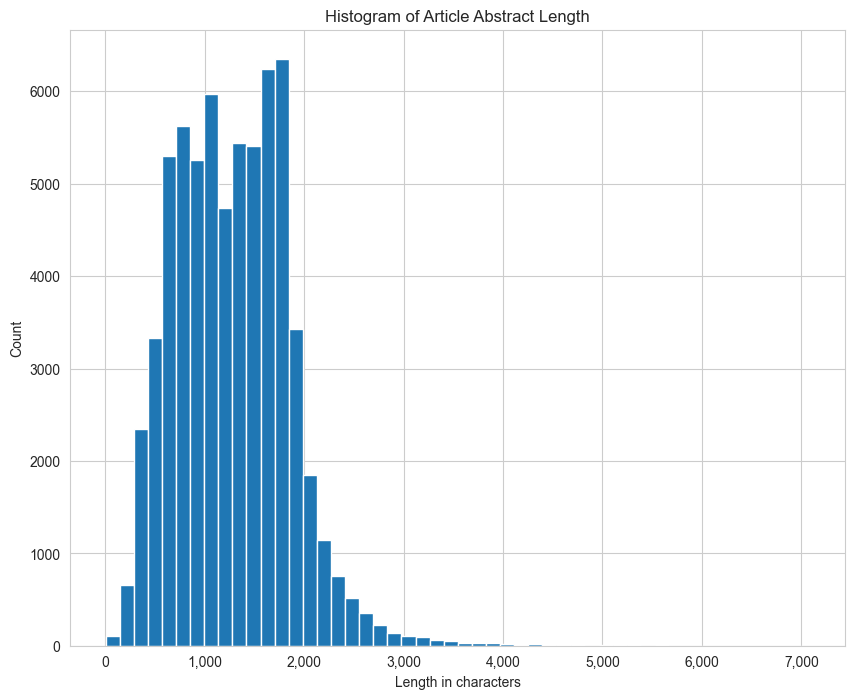

In [41]:
plot_length_histogram(abstract_lengths, 'Histogram of Article Abstract Length')

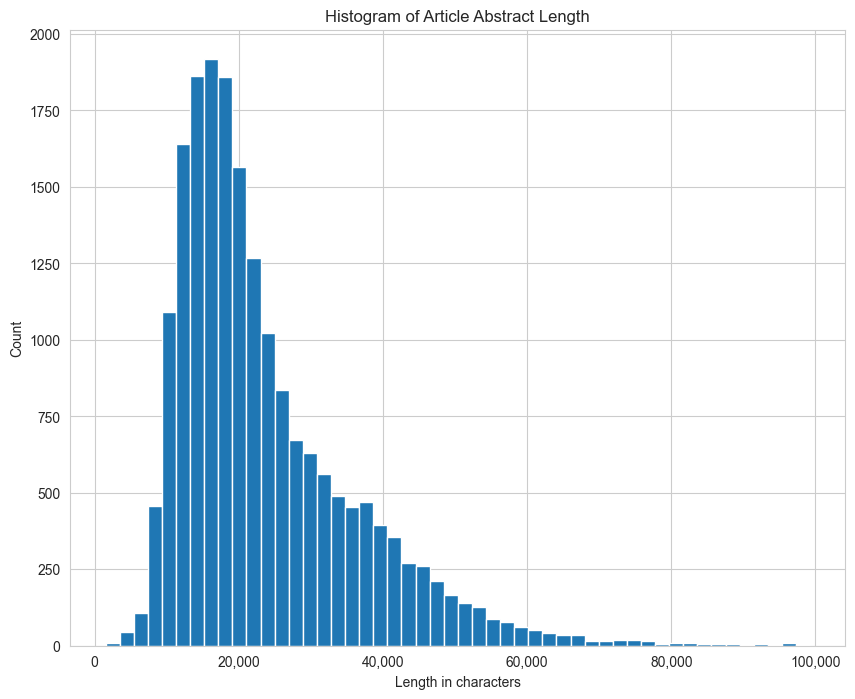

In [42]:
plot_length_histogram(fulltext_lengths, 'Histogram of Article Abstract Length', fulltext=True)

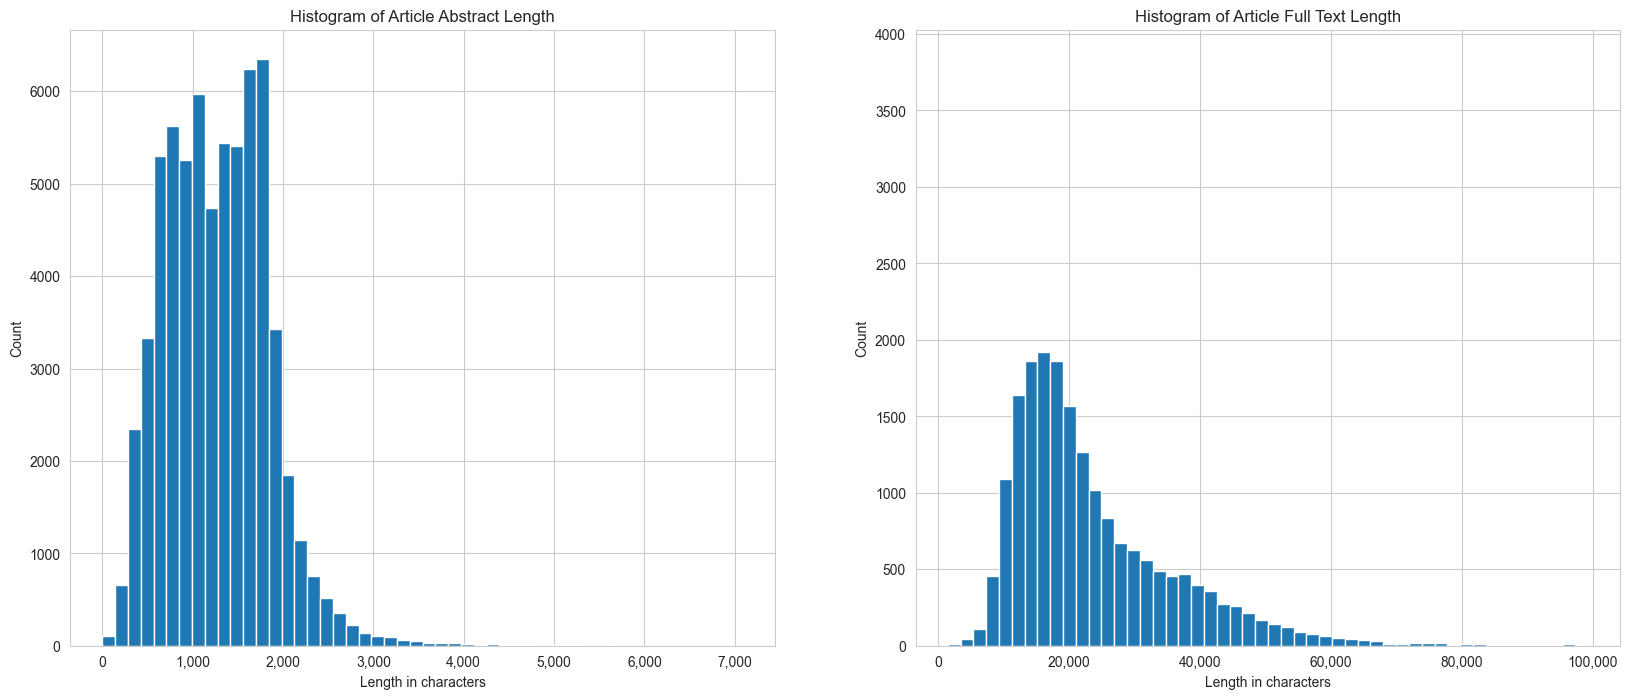

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_length_histogram(lengths, title, fulltext=False, ax=None):
    lengths = [l for l in lengths if l < 10e4 ]
    counts, bins = np.histogram(lengths, bins=50)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    else:
        fig = plt.gcf()
    ax.bar(bins[:-1], counts, width=bins[1:] - bins[:-1], align='edge')
    ax.set_xlabel('Length in characters')
    ax.set_ylabel('Count')
    ax.set_title(title)

    # Create a function to format the tick labels with comma separator
    def comma_fmt(x, pos):
        return '{:,.0f}'.format(x)

    # Set the x-axis tick formatter to the comma format function
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(comma_fmt))

    if fulltext:
        ax.set_ylim(bottom=0, top=ax.get_ylim()[1] * 2)

    return fig, ax

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey=False)

# Plot the histograms in the subplots
plot_length_histogram(abstract_lengths, 'Histogram of Article Abstract Length', ax=axs[0])
plot_length_histogram(fulltext_lengths, 'Histogram of Article Full Text Length', fulltext=True, ax=axs[1])

# Show the plot
plt.show()


## MeSH terms

In [122]:
import re

def get_mesh(m):
    mesh_terms = m.article.mesh_terms
    if not mesh_terms:
        return []
    # Regex pattern to parse keyword descriptions
    pattern = r"\bD\d+:(.+?)(?=;|$)"

    # Find all matches using the regex pattern
    kw = re.findall(pattern, mesh_terms)

    # Extract the keyword descriptions from the matches
    kw = [match for match in kw]
    return kw

def get_kw(m):
    kw = m.article.keywords
    if not kw:
        return []
    else:
        return kw.split('; ')
    return kw

def get_mesh_or_kw(getter, matches):
    # get all meshes if the paper has them
    meshes = [getter(m) for m in matches]
    meshes = [m for m in meshes if m]
    print(len(meshes))

    # flatten
    meshes = [m.title() for ls in meshes for m in ls]
    print(len(meshes))
    print(len(set(meshes)))

    # count 
    counts = sorted(list(Counter(meshes).items()), key=lambda x: x[1], reverse=True)
    return counts
    
mesh = get_mesh_or_kw(get_mesh, matches)
kw = get_mesh_or_kw(get_kw, matches)

48471
639151
13623
38842
187707
55951


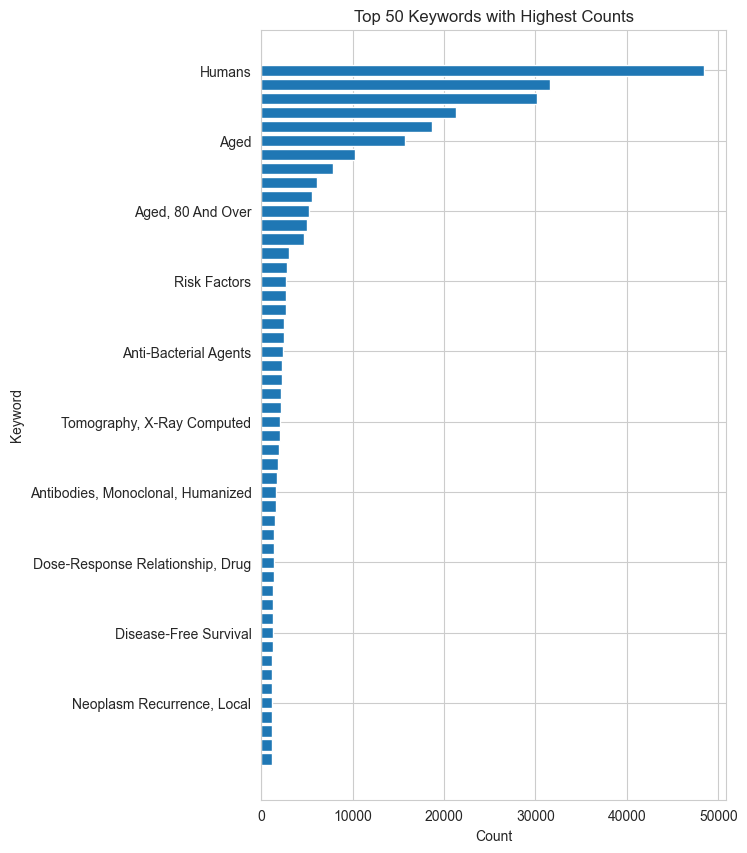

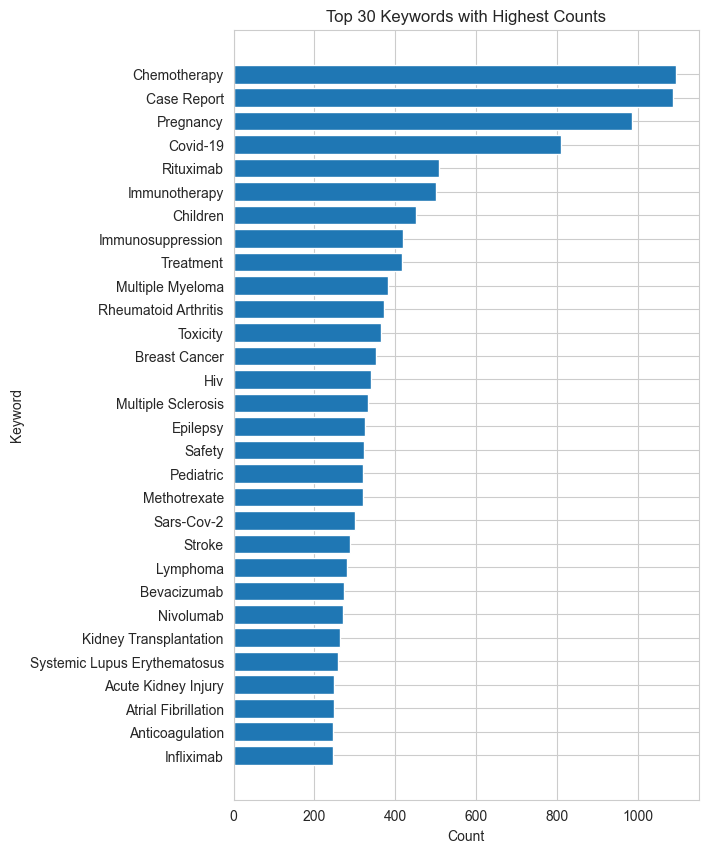

In [124]:
def create_horizontal_barplot(keywords_counts, n=5, i=1):
    """
    Creates a horizontal bar plot of the n keywords with the highest counts.

    Args:
        keywords_counts (list of tuples): List of tuples containing keyword and count information.
        n (int, optional): Number of keywords to plot with highest counts. Defaults to 5.
    """
    # Sort the keywords_counts list by count in descending order
    keywords_counts.sort(key=lambda x: x[1], reverse=True)
    
    # Extract the n keywords and counts
    keywords = [kw[0] for kw in keywords_counts[:n]][::-1]
    counts = [kw[1] for kw in keywords_counts[:n]][::-1]
    
    # Create the horizontal bar plot
    plt.figure(figsize=(6, 10))
    plt.barh(keywords, counts)

    # Show every i-th label on the y-axis
    if i > 1:
        plt.yticks(keywords[::-i])
    
    plt.xlabel('Count')
    plt.ylabel('Keyword')
    plt.title(f'Top {n} Keywords with Highest Counts')
    plt.show()

create_horizontal_barplot(mesh, n=50, i=5)
create_horizontal_barplot(kw, n=30, i=1)

## Sources of reports

In [132]:
# 1 = Physician
# 2 = Pharmacist
# 3 = Other health professional
# 4 = Lawyer
# 5 = Consumer or non-health professional
qualifications = [r.primarysource.qualification for m in matches for r in m.reports if r.primarysource]
print(len(qualifications))
qualifications = Counter(qualifications)
print(qualifications)

256240
Counter({'3': 147665, '1': 94316, '2': 9386, None: 4245, '5': 628})


In [151]:
companies = [r.companynumb for m in matches for r in m.reports if r.companynumb]
print(len(companies))
companies = [c for c in companies if '-' in c and c]
print(len(companies))
companies = [c.split('-')[1] for c in companies]
companies = sorted(Counter(companies).items(), key=lambda x: x[1], reverse=True)
companies

255750
240137


[('MYLANLABS', 25066),
 ('PFIZER INC', 22129),
 ('TEVA', 16983),
 ('SUN PHARMACEUTICAL INDUSTRIES LTD', 11449),
 ('JNJFOC', 9952),
 ('APOTEX', 8356),
 ('ACCORD', 7568),
 ('CIPLA LTD.', 7113),
 ('ALKEM LABORATORIES LIMITED', 6562),
 ('BAUSCH', 5873),
 ('ROCHE', 5445),
 ('BAXTER', 4863),
 ('LUPIN PHARMACEUTICALS INC.', 4526),
 ('STRIDES ARCOLAB LIMITED', 4404),
 ('FRESENIUS KABI', 4064),
 ('DRREDDYS', 3867),
 ('BAYER', 3563),
 ('AMGEN', 3314),
 ('GLAXOSMITHKLINE', 3282),
 ('SA', 3279),
 ('009507513', 2892),
 ('ALVOGEN', 2557),
 ('BRISTOL', 2255),
 ('B.I. PHARMACEUTICALS,INC./RIDGEFIELD', 2250),
 ('ENDO PHARMACEUTICALS INC', 2201),
 ('UCBSA', 2183),
 ('GILEAD', 1975),
 ('WATSON', 1924),
 ('ACTAVIS', 1671),
 ('ALLERGAN', 1628),
 ('ROXANE LABORATORIES, INC.', 1488),
 ('ASTELLAS', 1480),
 ('HIKMA PHARMACEUTICALS USA INC.', 1436),
 ('ABBVIE', 1378),
 ('GLENMARK PHARMACEUTICALS', 1363),
 ('AUROBINDO', 1192),
 ('CELLTRION INC.', 1135),
 ('ZYDUS', 1012),
 ('TAKEDA', 934),
 ('OTSUKA', 925),
 ('ML

### Check distribution of meddra versions

In [ ]:
# check all the meddra verions
versions = []
for m in matches:
    for report in m.reports:
        for reaction in report.patient.reaction:
            versions.append(reaction.reactionmeddraversionpt)

sorted_dict = dict(sorted(Counter(versions).items(), key=lambda x: x[1], reverse=True))

for key, value in sorted_dict.items():
    print(key, value)

### Check zero-percentage of fields

In [101]:
matches[0]

Match(article=Article(title='Arterial steroid injection therapy can inhibit the progression of severe acute hepatic failure toward fulminant liver failure.', title_normalized='arterial steroid injection therapy can inhibit the progression of severe acute hepatic failure toward fulminant liver failure', pmid='17075983', issue='12(41)', pages='6678-82', abstract='OBJECTIVE\nTo utilize transcatheter arterial steroid injection therapy (TASIT) via the hepatic artery to reduce hepatic macrophage activity in patients with severe acute hepatic failure.\n\n\nMETHODS\nThirty-four patients with severe acute hepatic failure were admitted to our hospital between June 2002 to June 2006 providing for the possibility of liver transplantation (LT). Seventeen patients were treated using traditional liver supportive procedures, and the other 17 patients additionally underwent TASIT with 1000 mg methylprednisolone per day for 3 continuous days.\n\n\nRESULTS\nOf the 17 patients who received TASIT, 13 were 

In [107]:
from collections import defaultdict

def count_zero_fields(obj_list):
    zero_counts = defaultdict(lambda: 0)
    for obj in obj_list:
        obj_fields = vars(obj)
        for field_name in obj_fields:
            field_value = obj_fields[field_name]
            # if not isinstance(field_value, object) and field_value == 0:
            #     if field_name not in zero_counts:
            #         zero_counts[field_name] = 1
            #     else:
            #         zero_counts[field_name] += 1
            if not field_value:
                zero_counts[field_name] += 1
    return zero_counts

In [112]:
# count article zero fields
articles = [m.article for m in matches]
print(len(articles))
article_zero_counts = count_zero_fields(articles)
article_zero_counts

65648


defaultdict(<function __main__.count_zero_fields.<locals>.<lambda>()>,
            {'fulltext': 46215,
             'fulltext_license': 46215,
             'keywords': 26806,
             'delete': 65648,
             'pmc': 65648,
             'other_id': 65621,
             'mesh_terms': 17177,
             'chemical_list': 25125,
             'affiliations': 2248,
             'references': 36096,
             'issn_linking': 1250,
             'pages': 4662,
             'doi': 7742,
             'issue': 1457,
             'authors': 10})

In [121]:
# get patients, drugs, reactions
patients = [r.patient for m in matches for r in m.reports]

drugs = []
reactions = []

for patient in patients:
    drug = patient.drug
    reaction = patient.reaction
    drugs.extend(drug)
    reactions.extend(reaction)

    del patient.drug
    del patient.reaction

print('number of patients:', len(patients))
print('number of drugs:', len(drugs))
print('number of reactions:', len(reactions))

number of patients: 256240
number of drugs: 1070211
number of reactions: 741940


In [126]:
# zero counts
print('number of patients:', len(patients))
patient_zero_counts = count_zero_fields(patients)
patient_zero_counts

number of patients: 256240


defaultdict(<function __main__.count_zero_fields.<locals>.<lambda>()>,
            {'patientagegroup': 210275,
             'patientonsetage': 79578,
             'patientonsetageunit': 79579,
             'patientsex': 65132,
             'patientweight': 243994,
             'summary': 230426})

In [127]:
# zero counts
print('number of drugs:', len(drugs))
drug_zero_counts = count_zero_fields(drugs)
drug_zero_counts

number of drugs: 1070211


defaultdict(<function __main__.count_zero_fields.<locals>.<lambda>()>,
            {'drugadministrationroute': 274872,
             'drugbatchnumb': 953140,
             'drugcumulativedosagenumb': 1065974,
             'drugcumulativedosageunit': 1066463,
             'drugenddate': 1040943,
             'drugenddateformat': 1040943,
             'drugintervaldosagedefinition': 921098,
             'drugintervaldosageunitnumb': 921098,
             'drugrecurreadministration': 887485,
             'drugseparatedosagenumb': 922870,
             'drugstartdate': 1004414,
             'drugstartdateformat': 1004414,
             'drugtreatmentduration': 1063321,
             'drugtreatmentdurationunit': 1063321,
             'drugrecurrence': 1063500,
             'drugdosageform': 879931,
             'drugdosagetext': 429925,
             'drugstructuredosagenumb': 756312,
             'drugstructuredosageunit': 756363,
             'drugauthorizationnumb': 727996,
             'action

In [128]:
# zero counts
print('number of reactions:', len(reactions))
reaction_zero_counts = count_zero_fields(reactions)
reaction_zero_counts

number of reactions: 741940


defaultdict(<function __main__.count_zero_fields.<locals>.<lambda>()>,
            {'reactionoutcome': 14077})

### Comparing chemical list with list of drugs

In [30]:
import re

def get_chemicallist(match):
    chemicals = []
    if match.article.chemical_list:
        chemicals = re.findall(r':([^;]+);?', match.article.chemical_list)
    return set([c.lower() for c in chemicals])

def get_drugs(match):
    drugs = []
    for report in match.reports:
        for drug in report.patient.drug:
            if drug.activesubstance:
                if drug.activesubstance.activesubstancename:
                    drugs.append(drug.activesubstance.activesubstancename)
    return set([d.lower() for d in drugs])

In [31]:
for i in range(20):
    print(i)
    print(get_chemicallist(matches[i]))
    print(get_drugs(matches[i]))



0
{'anti-inflammatory agents', 'methylprednisolone'}
{'methylprednisolone sodium succinate'}
1
set()
{'atropine sulfate', 'sevoflurane', 'midazolam', 'atropine'}
2
{'indoles', 'protein kinase inhibitors', 'nintedanib'}
{'nintedanib', 'methylprednisolone', 'prednisolone'}
3
{'clotrimazole', 'antifungal agents', 'tacrolimus', 'immunosuppressive agents'}
{'tacrolimus', 'mycophenolic acid', 'clotrimazole', 'lapine t-lymphocyte immune globulin', 'methylprednisolone', 'prednisone'}
4
set()
{'paclitaxel', 'zoledronic acid', 'carboplatin'}
5
set()
{'aspirin'}
6
{'antineoplastic agents, immunological', 'immune checkpoint inhibitors'}
{'ipilimumab', 'nivolumab'}
7
set()
{'tacrolimus', 'mycophenolic acid', 'cyclosporine', 'methotrexate', 'everolimus', 'prednisolone', 'azathioprine'}
8
set()
{'estradiol', 'unspecified ingredient'}
9
set()
{'letrozole'}
10
{'nivolumab'}
{'paclitaxel', 'nivolumab'}
11
set()
{'pravastatin\\pravastatin sodium', 'atenolol', 'hydrochlorothiazide', 'aspirin', 'chlorproma